# Vector embedding-based change detection -- ???

In [1]:
!pip install pystac_client==0.6.1 stackstac==0.4.4

  Obtaining dependency information for stackstac==0.4.4 from https://files.pythonhosted.org/packages/81/22/3bb47276aa898638fcaf24bd73db6acc8249cfaccb6b1021e579045c1868/stackstac-0.4.4-py3-none-any.whl.metadata
  Obtaining dependency information for pystac>=1.7.0 from https://files.pythonhosted.org/packages/d2/35/efb3ada4f8db776144d786338a41d38e5128f2c1e4a86b681c658fe1151e/pystac-1.8.3-py3-none-any.whl.metadata
  Obtaining dependency information for dask[array]>=2022.1.1 from https://files.pythonhosted.org/packages/f4/b9/ea749b059b5e5eab6231fcd65b3680551a65392c9a37352ddffc17ce8616/dask-2023.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec>=2021.09.0 from https://files.pythonhosted.org/packages/e3/bd/4c0a4619494188a9db5d77e2100ab7d544a42e76b2447869d8e124e981d8/fsspec-2023.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-metadata>=4.13.0 from https://files.pythonhosted.org/packages/cc/37/db7ba97e676af155f5fcb1a35466f446eadc9104e25b8

---

In [2]:
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import download_if_needed, json_to_file, file_to_json
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm.auto import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

## Get time-series of Sentinel-2 images from STAC API

In [3]:
import pystac_client
import stackstac

Iskenderun, Turkey

In [19]:
bbox = Box(xmin=36.188974, ymin=36.599219, xmax=36.200175, ymax=36.590548)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [20]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=["sentinel-2-l2a"],
    # datetime="2017-01-01/2023-12-31",
    datetime="2023-01-01/2023-05-01",
    query={"eo:cloud_cover": {"lt": 5}},
).item_collection()
len(items)

10

In [21]:
stack = stackstac.stack(items, epsg=32637)
stack

<xarray.DataArray 'stackstac-b6e79e5fdd0872eb9c91e8ecbe59f990' (time: 10,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(10, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2023-01-05...
    id                                       (time) <U24 'S2B_37SBA_20230105_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 2e+05 ... 3.098e+05
  * y                                        (y) float64 4.1e+06 ... 3.99e+06
    s2:vegetation_percentage                 (time) float64 21.14 24.72 ... 38.9
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32637
Attributes:
    spec:        RasterSpec(epsg=32637, bounds=(199980.0, 3990240.0, 309780.0...
    crs:         epsg:32637
    transform:   | 10.00, 0.00, 199980.00|\n| 0.00,-10.00, 4100040.00|\n| 0.0...
    resolution:  10.0

### Convert to a Raster Vision `RasterSource`

In [22]:
data_array = stack
data_array = data_array.sel(
    band=[
        'coastal', # B01
        'blue', # B02
        'green', # B03
        'red', # B04
        'rededge1', # B05
        'rededge2', # B06
        'rededge3', # B07
        'nir', # B08
        'nir08', # B8A
        'nir09', # B09
        'swir16', # ???
        'swir16', # B11
        'swir22', # B12
    ])

### Create the `RasterSource`

In [23]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)

In [24]:
xmin_px, ymin_px = crs_transformer.map_to_pixel((bbox.xmin, bbox.ymin))
valid_ts, _ = np.where(~np.isnan(data_array.isel(x=xmin_px, y=ymin_px, band=[0]).to_numpy()))
data_array = data_array.isel(time=valid_ts)
data_array

<xarray.DataArray 'stackstac-b6e79e5fdd0872eb9c91e8ecbe59f990' (time: 10,
                                                                band: 13,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<getitem, shape=(10, 13, 10980, 10980), dtype=float64, chunksize=(1, 2, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2023-01-05...
    id                                       (time) <U24 'S2B_37SBA_20230105_...
  * band                                     (band) <U12 'coastal' ... 'swir22'
  * x                                        (x) float64 2e+05 ... 3.098e+05
  * y                                        (y) float64 4.1e+06 ... 3.99e+06
    s2:vegetation_percentage                 (time) float64 21.14 24.72 ... 38.9
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object 60 10 10 ... 20 20 20
    common_name                              (band) object 'coastal' ... 'swi...
    center_wavelength                        (band) object 0.443 0.49 ... 2.19
    full_width_half_max                      (band) object 0.027 0.098 ... 0.242
    epsg                                     int64 32637
Attributes:
    spec:        RasterSpec(epsg=32637, bounds=(199980.0, 3990240.0, 309780.0...
    crs:         epsg:32637
    transform:   | 10.00, 0.00, 199980.00|\n| 0.00,-10.00, 4100040.00|\n| 0.0...
    resolution:  10.0

In [25]:
# means = np.array([756.4, 889.6, 1151.7, 1307.6, 1637.6, 2212.6, 2442.0, 2538.9, 2602.9, 2666.8, 2388.8, 2388.8, 1821.5])
# stds = np.array([1111.4, 1159.1, 1188.1, 1375.2, 1376.6, 1358.6, 1418.4, 1476.4, 1439.9, 1582.1, 1460.7, 1460.7, 1352.2])
# stats = RasterStats(means, stds)
# stats.save('SSL4EO_stats.json')

In [26]:
stats_tf = StatsTransformer.from_stats_json('SSL4EO_stats.json')

In [27]:
raster_source = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    channel_order=list(range(len(data_array.band))),
    temporal=True
)
raster_source.shape


KeyboardInterrupt



In [ ]:
T = raster_source.shape[0]
t_strs = np.array([str(_t.date()) for _t in raster_source.data_array.time.to_series().to_list()])

In [ ]:
# window = raster_source.extent.get_windows(500, 500)[22*2 + 12]
window = raster_source.crs_transformer.map_to_pixel(bbox).pad(50, 51, 51, 51)

In [ ]:
plt.close('all')

skip = 1
ts = range(0, T, skip)
t_strs_ = t_strs[::skip]

ncols = 5
nrows = int(math.ceil(len(ts) / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)
with tqdm(zip(ts, t_strs_, axs.flat), total=len(ts)) as bar:
    for t, t_str_t, ax in bar:
        chip_t = raster_source.get_chip(window, bands=[3, 2, 1], time=t)
        ax.imshow(chip_t)
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(t_str_t, fontsize=8)
if t < len(axs.flat) - 1:
    for ax in axs.flat[t + 1:]:
        ax.axis('off')
plt.show()

---

## Generate embeddings

### Get model

https://github.com/zhu-xlab/SSL4EO-S12

MoCo	ResNet18	S2-L1C 13 bands

In [25]:
from torch import nn
from torchvision.models import resnet18
from rastervision.pytorch_learner.utils import adjust_conv_channels

In [26]:
sd = torch.load('./B13_rn18_moco_0099_ckpt.pth')
sd_encoder_q = {k: v for k, v in sd['state_dict'].items() if (k.startswith('module.encoder_q') and not '.fc.' in k)}
sd_encoder_q_no_prefix = {k.replace('module.encoder_q.', ''): v for k, v in sd_encoder_q.items()}

In [27]:
model = resnet18(weights=None)
model.fc = nn.Identity()
model.conv1 = adjust_conv_channels(model.conv1, 13, pretrained=False)
model.load_state_dict(sd_encoder_q_no_prefix)
model = model.to(device=DEVICE)
model = model.eval()

---

### Run inference

In [28]:
def get_embedding(model: nn.Module, x: np.ndarray) -> np.ndarray:
    x = torch.from_numpy(x).float()
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = x.to(device=DEVICE)
    out = model(x)
    out = out.cpu().numpy()
    return out

In [150]:
skip = 1
ts = range(0, T, skip)
t_strs_ = t_strs[::skip]

embeddings = []
with tqdm(zip(ts, t_strs), total=len(ts)) as bar, torch.inference_mode():
    for t, t_str in bar:
        chip_t = raster_source.get_chip(window, time=t)
        embedding_t = get_embedding(model, chip_t).squeeze()
        year, _, _ = t_str.split('-')
        year = int(year)
        embeddings.append(embedding_t)

embeddings = np.stack(embeddings)
embeddings.shape

  0%|          | 0/18 [00:00<?, ?it/s]

In [155]:
embeddings_json = dict(
    embeddings=embeddings, 
    t_strs=t_strs, 
    embeddings_flood=embeddings_flood, 
    t_strs_flood=t_strs_flood,
    embeddings_2023=embeddings_2023,
    t_strs_2023=t_strs_2023,
)
json_to_file(ensure_json_serializable(embeddings_json), 'seasonal_variation_embeddings.json')

---

## Analysis

In [2]:
embeddings_json = file_to_json('seasonal_variation_embeddings.json')
embeddings = np.array(embeddings_json['embeddings'])
t_strs = np.array(embeddings_json['t_strs'])
embeddings_flood = np.array(embeddings_json['embeddings_flood'])
t_strs_flood = np.array(embeddings_json['t_strs_flood'])
embeddings_2023 = np.array(embeddings_json['embeddings_2023'])
t_strs_2023 = np.array(embeddings_json['t_strs_2023'])

In [3]:
mask = t_strs != '2018-11-18'
t_strs = t_strs[mask]
embeddings = embeddings[mask]

In [4]:
from datetime import datetime

t_doy = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs])
t_doy_flood = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_flood])
t_doy_2023 = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_2023])

In [8]:
datetime.strptime(t_strs[0], '%Y-%m-%d').timetuple().tm_year

2017

In [21]:
def to_t_day(t_str):
    return (datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_year + 
     np.clip(datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday / 365, 0, 1))

In [22]:
t_day = np.array([to_t_day(t_str) for t_str in t_strs])
t_day_flood = np.array([to_t_day(t_str) for t_str in t_strs_flood])
t_day_2023 = np.array([to_t_day(t_str) for t_str in t_strs_2023])

In [5]:
mu = embeddings.mean(axis=0)
sigma = embeddings.std(axis=0)

In [6]:
z = np.clip(np.nan_to_num((embeddings - mu) / sigma), -6, 6)
z_flood = np.clip(np.nan_to_num((embeddings_flood - mu) / sigma), -6, 6)
z_2023 = np.clip(np.nan_to_num((embeddings_2023 - mu) / sigma), -6, 6)

---

### Clustering

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE()
tsne.fit(embeddings)

TSNE()

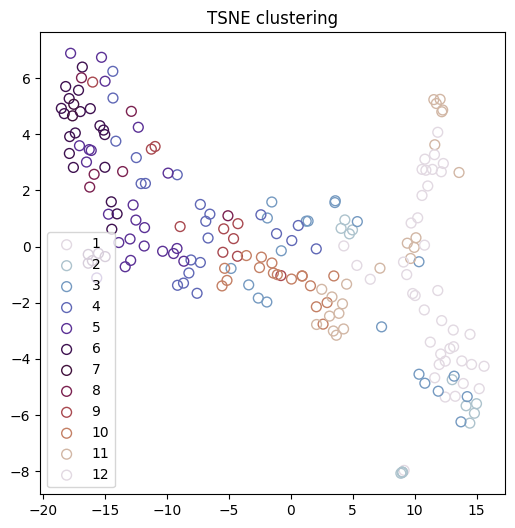

In [59]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)
cmap = plt.get_cmap('twilight')
for m in range(1, 12 + 1):
    m_inds = np.where([int(s.split('-')[1]) == m for s in t_strs])[0]
    tsne_emb = tsne.embedding_[m_inds]
    ax.scatter(tsne_emb[:, 0], tsne_emb[:, 1], s=50, ec=cmap((m - 1) / 11), fc='none', alpha=1, label=f'{m}')

ax.legend()
ax.set_title('TSNE clustering')

plt.show()

---

### Statistical model

#### PCA

In [13]:
from sklearn.decomposition import PCA, IncrementalPCA, FastICA, FactorAnalysis

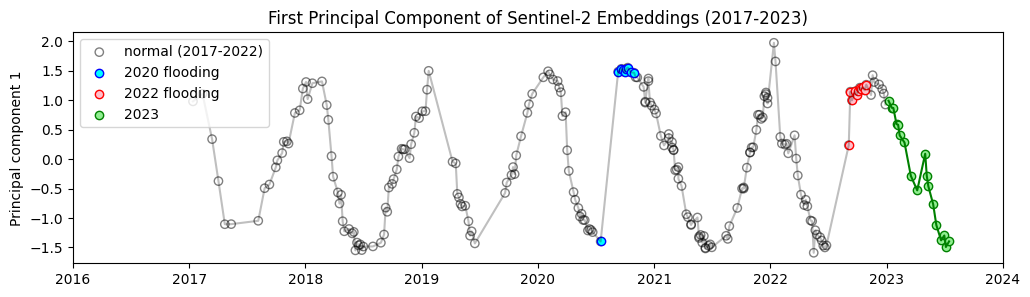

In [34]:
pca = PCA(whiten=True)
# pca = FactorAnalysis()
pca.fit(embeddings)
pc = 0

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 3), squeeze=True)

pca_emb = pca.transform(embeddings)
x = t_day
ax.scatter(x, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal (2017-2022)')
ax.plot(x, pca_emb[:, pc], c='k', alpha=0.25)

flood_inds_2020 = np.where([t_str.startswith('2020') for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2020])
x = t_day_flood[flood_inds_2020]
ax.scatter(x, pca_emb[:, pc], ec='b', fc='cyan', label='2020 flooding')

flood_inds_2022 = np.where([t_str.startswith('2022') for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2022])
x = t_day_flood[flood_inds_2022]
ax.scatter(x, pca_emb[:, pc], ec='r', fc='pink', label='2022 flooding')

pca_emb = pca.transform(embeddings_2023)
x = t_day_2023
ax.scatter(x, pca_emb[:, pc], ec='g', fc='lightgreen', label='2023')
ax.plot(x, pca_emb[:, pc], c='g')

# ax.legend(loc='upper left', framealpha=0.1)
ax.legend()
# ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
# ax.set_xlabel('Month')
ax.set_xlim((2016, 2024))
ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

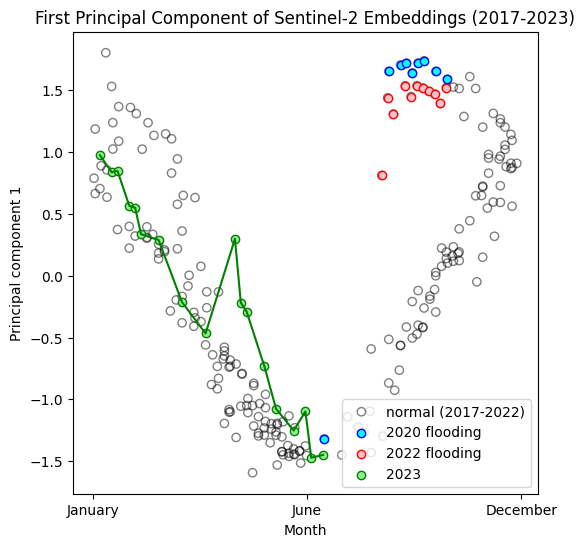

In [371]:
# pca = PCA(whiten=True)
pca = FactorAnalysis()
pca.fit(embeddings)
pc = 0

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal (2017-2022)')

flood_inds_2020 = np.where([t_str.startswith('2020') for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2020])
x = np.clip(t_doy_flood[flood_inds_2020] / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='b', fc='cyan', label='2020 flooding')

flood_inds_2022 = np.where([t_str.startswith('2022') for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2022])
x = np.clip(t_doy_flood[flood_inds_2022] / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='r', fc='pink', label='2022 flooding')

pca_emb = pca.transform(embeddings_2023)
x = np.clip(t_doy_2023 / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='g', fc='lightgreen', label='2023')
ax.plot(x, pca_emb[:, pc], c='g')

ax.legend()
ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

In [26]:
fig.savefig('embedding_seasonal_variation.png', bbox_inches='tight', pad_inches=0.2)

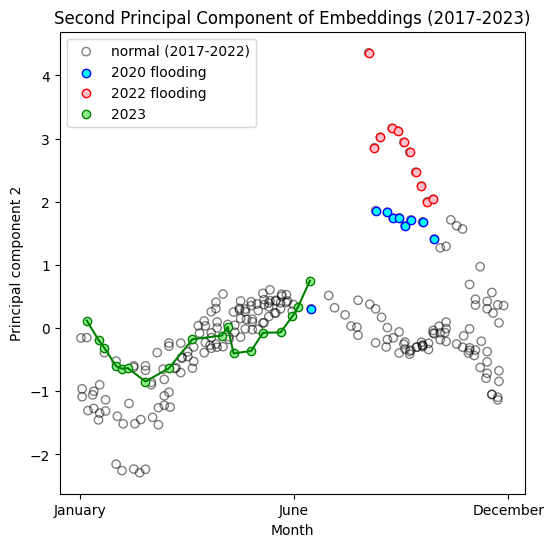

In [365]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

pc = 1

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal (2017-2022)')

flood_inds_2020 = np.where([t_str.startswith('2020') for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2020])
x = np.clip(t_doy_flood[flood_inds_2020] / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='b', fc='cyan', label='2020 flooding')

flood_inds_2022 = np.where([t_str.startswith('2022') for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2022])
x = np.clip(t_doy_flood[flood_inds_2022] / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='r', fc='pink', label='2022 flooding')

pca_emb = pca.transform(embeddings_2023)
x = np.clip(t_doy_2023 / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='g', fc='lightgreen', label='2023')
ax.plot(x, pca_emb[:, pc], c='g')

ax.legend()
ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('Second Principal Component of Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

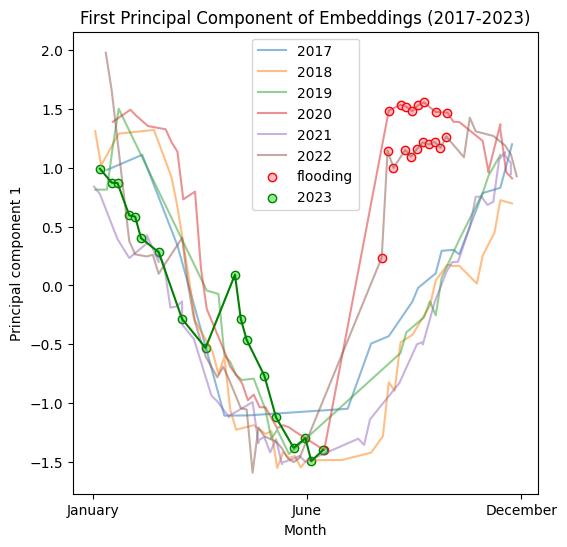

In [366]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

cmap = plt.get_cmap('tab10')
for i, year in enumerate(range(2017, 2023)):
    year_inds = np.where([t_str.startswith(str(year)) for t_str in t_strs])[0]
    pca_emb = pca.transform(embeddings[year_inds])
    x = np.clip(t_doy[year_inds] / 365, 0, 1)
    ax.plot(x, pca_emb[:, 0], c=cmap(i), alpha=0.5, label=f'{year}')

pca_emb = pca.transform(embeddings_flood)
x = np.clip(t_doy_flood / 365, 0, 1)
# x = np.sin(x * np.pi)
ax.scatter(x, pca_emb[:, 0], ec='r', fc='pink', label='flooding')

pca_emb = pca.transform(embeddings_2023)
x = np.clip(t_doy_2023 / 365, 0, 1)
ax.scatter(x, pca_emb[:, 0], ec='g', fc='lightgreen', label='2023')
ax.plot(x, pca_emb[:, 0], c='g')

ax.legend()
ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel('Principal component 1')

plt.show()

---

In [257]:
def t_to_feats(t):
    feat_1 = np.sin(t * np.pi * 2)
    feat_2 = np.cos(t * np.pi * 2)
    # feat_3 = feat_1 * feat_2
    return np.stack([feat_1, feat_2], axis=1)

In [198]:
from sklearn.linear_model import (
    LinearRegression, Ridge, BayesianRidge, HuberRegressor, RANSACRegressor,
    TheilSenRegressor, )

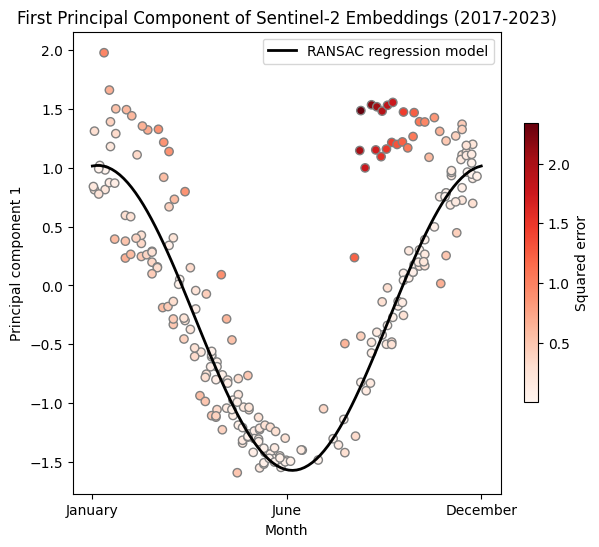

In [367]:
pca = PCA(whiten=True)
pca.fit(embeddings)
pc = 0

lr = RANSACRegressor()
Y = pca.transform(embeddings)[:, pc]
t = np.clip(t_doy / 365, 0, 1)
X = t_to_feats(t)
lr.fit(X, Y)

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)
cmap = plt.get_cmap('Reds')

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

pca_emb = pca.transform(embeddings_2023)
x = np.clip(t_doy_2023 / 365, 0, 1)
# ax.plot(x, pca_emb[:, pc], c='g')
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='RANSAC regression model')
ax.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, fraction=0.03, label='Squared error')

ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel('Principal component 1')
plt.show()

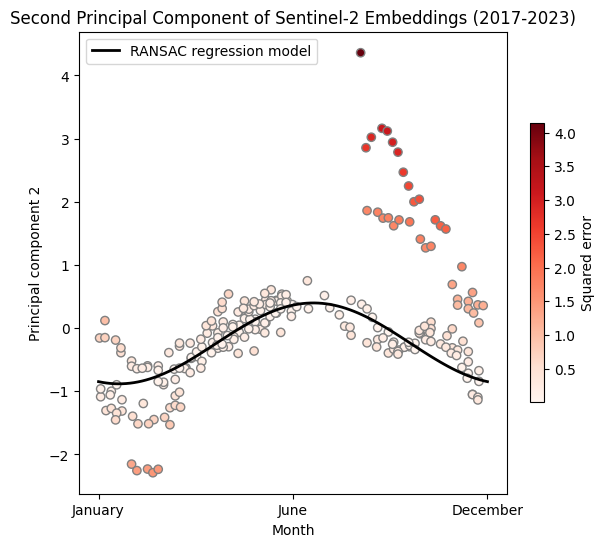

In [368]:
pca = PCA(whiten=True)
pca.fit(embeddings)
pc = 1

lr = RANSACRegressor()
Y = pca.transform(embeddings)[:, pc]
t = np.clip(t_doy / 365, 0, 1)
X = t_to_feats(t)
lr.fit(X, Y)

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)
cmap = plt.get_cmap('Reds')

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

pca_emb = pca.transform(embeddings_2023)
x = np.clip(t_doy_2023 / 365, 0, 1)
# ax.plot(x, pca_emb[:, pc], c='g')
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='RANSAC regression model')
ax.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, fraction=0.03, label='Squared error')

ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('Second Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel(f'Principal component {pc + 1}')
plt.show()

In [324]:
lr.residual_threshold